## Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from tqdm import tqdm

C:\Users\usmim\AppData\Local\Temp\ipykernel_14500\4073521120.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## SIR  Model Meaning

Run on deterministic differential equations but can be used with stochastic or random framework
Three parts
* Suseptible - not infected 
* Infected - infected
* Recovered - recovered, immune or deceased

## Mathematical SIR Model or Compartmental Epidemeology Model

* At each time step t 
* a certain amount of people are traversing from S to I and from I to R, 
* the total number of individuals N = S+I+R is constant.

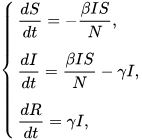


Here :
* new suceptible are beta * S * I / N i.e dS/dt
* new recoveries are gamma * I i.e dR/dt
* new infected is dS/dt - dR/dt


Important Points to note:

S(t) + I(t) + R(t) = N (constant at any point in time)

differentiating with respect to time

dS/dt + dI/dt + dR/dt = 0

* beta

It represents the effective contact rate of the disease, i.e., the probability of transmitting the disease from an infectious individual to a susceptible individual per unit time.

beta = infection_chance * average_contacts

* gamma

It represents the recovery rate, i.e., the rate at which infectious individuals recover and are removed from the infectious compartment.

gamma = 1/recovery rate

In [4]:
class SIRModel:
    
    """ parameters:
    total_agents: total population
    initial_infected: initial infected population
    infection_chance: infection chance
    average_contacts: average contacts per day
    recovery_days: recovery days 
    """
    
    def __init__(self, total_agents, initial_infected, infection_chance, average_contacts, recovery_days):
       
        # Initialize parameters
        self.total_agents = total_agents # Total population
        self.initial_infected = initial_infected # Initial infected population
        self.infection_chance = infection_chance # infection chance
        self.average_contacts = average_contacts # average contacts per day
        self.recovery_days = recovery_days # recovery days
        
        # Initialize compartments
        self.S = total_agents - initial_infected # initial susceptible population is total population at time zero
        self.I = initial_infected # initial infected population which is zero
        self.R = 0 # initial recovered population which is zero
        
        # Lists to store values over time for S, I, and R
        self.S_history = [] 
        self.I_history = []
        self.R_history = []
        
        # Calculate constants using formulae
        self.beta = infection_chance * average_contacts
        self.gamma = 1.0 / recovery_days
        
        # Print initialized parameters
        print("SIR Model initialized with:")
        print("Beta:", self.beta)
        print("Gamma:", self.gamma)

    
    def calculate_step(self):
        # Calculate total population
        N = self.S + self.I + self.R
        
        # Store current values
        S = self.S
        I = self.I
        
        # Calculate using SIR model differential equations
        new_susceptible = self.beta * S * I / N
        new_recoveries = self.gamma * I
        
        # Update values
        self.S -= new_susceptible
        self.I += new_susceptible - new_recoveries # new infections
        self.R += new_recoveries
        
        # Record values for this step in lists
        self.S_history.append(self.S)
        self.I_history.append(self.I)
        self.R_history.append(self.R)


In [5]:
total_agents = 10000
duration = 120
initial_infected = 100
allStats = []

sir_model = SIRModel(total_agents, initial_infected, infection_chance=0.025, average_contacts=9, recovery_days=10)
print("Simulate SIR Model")
for i in tqdm(range(duration)):        
    sir_model.calculate_step()

SIR Model initialized with:
Beta: 0.225
Gamma: 0.1
Simulate SIR Model


100%|██████████| 120/120 [00:00<?, ?it/s]


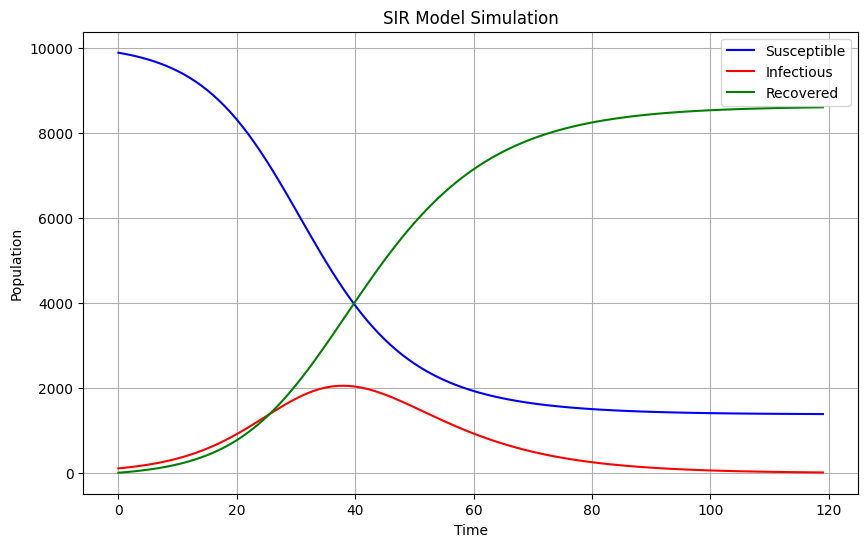

In [6]:
x = np.linspace(0,duration-1,duration)
plt.figure(figsize=(10, 6))
# Plot susceptible individuals over time
plt.plot(x, sir_model.S_history, label='Susceptible', color='blue')
# Plot infectious individuals over time
plt.plot(x, sir_model.I_history, label='Infectious', color='red')
# Plot recovered individuals over time
plt.plot(x, sir_model.R_history, label='Recovered', color='green')

plt.title('SIR Model Simulation')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

However, we assume that the population is homogeneous, organized into three well defined, perfectly mixed groups.
The interactions that are modeled are only on average.
Every infected individual infects on each day a fixed number of people and a constant fraction of all infected individuals is cured each day.

## Agent Based SIR Model

In [7]:
# creating a dataframe of total population and their current state
# state 0 is susceptible, 1 is infected, 2 is recovered

total_agents = 10000
state = np.zeros(total_agents)

data = {"state": state} 

df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   state   10000 non-null  float64
dtypes: float64(1)
memory usage: 78.3 KB


The infect and recover functions are called at every time step.

In [53]:
# function to infect the agents based on the contacts and probability
def infect(df, contacts, probability=1.0):
    # Count how many times each contact appears
    unique, counts = np.unique(contacts, return_counts=True)
    
    # generate a random number between 0 to 1 for each unique agent in the contact list 
    # and update the state from sucseptible (0) to infected (1) 
    # if this is below a probability threshold.
    random_prob = np.random.uniform(0, 1, len(unique))

    # Get the current state of each unique contact
    state = df.loc[unique, "state"]
    
    # Calculate the probability of infection for each unique contact
    probability = 1 - np.power(1 - probability, counts)
    
    # Determine if each contact is infected
    change = np.array(random_prob <= probability).astype(int)
    
    # Update the state of contacts based on infection
    df.loc[unique, "state"] = state + np.maximum(change * (1 - state), 0)

In [54]:
def recover(df, recovery_probability=1.0):
    
    # Generate random numbers for each infected agent
    random_prob = np.random.uniform(0, 1, len(df[df["state"] == 1]))
    
    # Determine if each infected agent recovers based on the recovery probability which for now has been set to 1
    chance = np.array(random_prob <= recovery_probability).astype(int)
    
    # Update the state of infected agents who recover
    # the state will be set to 2 for recovered if chance is 1
    df.loc[df["state"] == 1, "state"] = 1 + chance  
    
    return df

In [55]:
def init(total_agents=1000, num_infected=1):
    # Create an array representing the state of each agent (0 for susceptible)
    state = np.zeros(total_agents)
    
    # Create an array representing the neighborhood of each agent (currently not used)
    # neighborhood = np.zeros(total_agents)
    
    # Create a DataFrame to store the state and neighborhood data
    df = pd.DataFrame({"state": state})
    
    # Randomly select 'num_infected' agents to be initially infected
    patient_zero = np.random.choice(df.index, num_infected, replace=False)
    
    # Infect the initially selected agents
    df.loc[patient_zero, "state"] = 1  # Set state to 1 for infected
    
    return df

In [56]:
def step(df):
    # Count the number of infected individuals
    n_infected = (df["state"] == 1).sum()
    
    # Select random contacts for infected individuals
    contacts = np.random.choice(df.index, random_contacts * n_infected, replace=True)
    
    # Infect the selected contacts
    infect(df, contacts, chance_of_infection)
    
    # Recover infected individuals
    recover(df, chance_of_recovery)

In [57]:
def simulate(df, stats, nSteps=100, mode="random", nRandomContacts=0):
    # Iterate over the specified number of simulation steps
    for _ in tqdm(range(nSteps)):
        # Perform a simulation step
        step(df)
        
        # Collect statistics at each step
        stats["Susceptible"].append(df["state"].eq(0).sum())    
        stats["Infected"].append(df["state"].eq(1).sum())
        stats["Recovered"].append(df["state"].eq(2).sum())

In [60]:
# Define parameters
random_contacts = 9
chance_of_infection = 0.025
days_cured_after = 10
chance_of_recovery = 1.0 / days_cured_after
num_experiments = 10
num_agents = 10000
num_steps = 150
num_patient_zero = 5


In [61]:
st = {"Infected": [], "Recovered": [], "Susceptible": []}
df = init(num_agents, num_patient_zero)
print(df.describe())

# Simulate one run and collect statistics
simulate(df, stats=st, nSteps=num_steps)
all_stats.append(st)
print(all_stats)

              state
count  10000.000000
mean       0.000500
std        0.022356
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


100%|██████████| 150/150 [00:00<00:00, 261.53it/s]

[{'Infected': [4, 4, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Removed': [1, 1, 2, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], 'Susceptible': [9995, 9995, 9995, 9995, 9995, 9995, 9995, 9995, 9995, 9

<class 'list'>
